# Week 12 - Learning Word Embeddings
📚 Source: 😊[Day 12 - Special Data Types: Natural Language Processing](https://github.com/core-skills/12-text-processing) *repository*

## Notebook Overview
In this notebook, we'll further explore the use of word embeddings using Word2Vec via the Gensim API. We'll train embeddings on two datasets (corpora) pertaining to general domains (hotel reviews) and specialised domains (geological survey reports) and explore the impacts the corpora have on the resulting semantic and syntactic meaning representation.

This notebook uses two types of datasets.
1. General Domain: 259,000 *hotel reviews* from [OpinRank](https://archive.ics.uci.edu/ml/datasets/opinrank+review+dataset) 
2. Domain Specific: *geological surveys* (GSWA)

This notebook was partially adapted from: [*Kavita Ganesan's tutorial*](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/) ([*repository*](https://github.com/kavgan/data-science-tutorials/tree/master/word2vec))

## Table of Contents
1. [Understanding Word2Vec parameters](#word2vec_parameters)
2. [Building general-domain word vectors](#general-domain_word_vectors)
3. [Building domain-specific word vectors](#domain-specific_word_vectors)

## Notebook Setup

In [1]:
!pip install gensim==4.2.0 bokeh pandas sklearn matplotlib numpy

You should consider upgrading via the 'c:\users\tyler\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


Lets load in the package [nb_black](https://github.com/dnanhkhoa/nb_black) to auto-format our code as we go. Formatting code is useful as it easier to collaborate and interpret what we write.

In [2]:
# Package for ensuring code we write is formatted nicely (see: https://github.com/dnanhkhoa/nb_black)
%load_ext nb_black

<IPython.core.display.Javascript object>

### Import Packages
Standard packages

In [3]:
import gzip
from typing import List
import zipfile
import json
from urllib.request import urlretrieve
import os
from pathlib import Path

<IPython.core.display.Javascript object>

Third party packages
- [gzip](https://docs.python.org/3/library/gzip.html) - library that we use to read data in .zip format
- [bokeh](https://bokeh.org/) - library that we use to interactively visualise word vectors 
- [gensim](https://radimrehurek.com/gensim/) - library that we will use to experiment with word embeddings/vectors

In [4]:
import gensim
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

<IPython.core.display.Javascript object>

### Notebook configuration and load helper functions

In [5]:
# Need the interactive Tools for Matplotlib
%matplotlib inline
# Plot formatting
plt.rcParams["figure.figsize"] = [12,6]
font = {'size':12}
matplotlib.rc('font', **font)

<IPython.core.display.Javascript object>

In [6]:
def read_input(input_file_path: str) -> List:
    '''Parses input file which is in gzip format'''
    assert input_file_path.endswith('.gz')
    
    corpus = []
    with gzip.open(input_file_path, 'rb') as f:
        for line in f: 
            # Perform pre-processing and return a list of words from each review text 
            corpus.append(gensim.utils.simple_preprocess(line))
    return corpus

<IPython.core.display.Javascript object>

In [7]:
def prettify_similarities(similarities: List[tuple]) -> List[str]:
    ''' Prettifies list of word similarities produced by Gensim'''
    longest_str = max([len(sim[0]) for sim in similarities])
    print("\n".join([f'{idx+1}.\t{sim[0]:{longest_str+1}}\t{sim[1]*100:0.1f}%' for idx, sim in enumerate(similarities)]))

<IPython.core.display.Javascript object>

## Download Notebook Data
Here we'll download the required data for this notebook if it isn't already in our workspace. This will take a few minutes if nothing already exists.

In [8]:
resources = {'reviews_data.txt.gz': 'https://www.dropbox.com/s/o5oqgvmfg575x2u/reviews_data.txt.gz?dl=1',
             'wamex_xml.zip': 'https://www.dropbox.com/s/dp8celry10spy3t/wamex_xml.zip?dl=1',
             'word2vec_reviews.bin': 'https://www.dropbox.com/s/i89pes762o2qsdo/word2vec_reviews.bin?dl=1',
             'word2vec_reviews.bin.wv.vectors.npy':'https://www.dropbox.com/s/1ulsr8v0m9x3ia3/word2vec_reviews.bin.wv.vectors.npy?dl=1',
             'word2vec_reviews.bin.syn1neg.npy':'https://www.dropbox.com/s/asz9eey86nmv7xb/word2vec_reviews.bin.syn1neg.npy?dl=1',
             'word2vec_gswa.bin': 'https://www.dropbox.com/s/5f2fioeq8y1mn73/word2vec_gswa.bin?dl=1',
             'word2vec_gswa.bin.wv.vectors.npy': 'https://www.dropbox.com/s/bgwl44wl3m2pq1x/word2vec_gswa.bin.wv.vectors.npy?dl=1',
             'word2vec_gswa.bin.syn1neg.npy': 'https://www.dropbox.com/s/wy24038lcegifpf/word2vec_gswa.bin.syn1neg.npy?dl=1'}

<IPython.core.display.Javascript object>

In [9]:
for fname, url in resources.items():
    
    fpath = f'../data/{fname}'
    
    if os.path.isfile(fpath):
        print(f'{fname} exists')
        continue
    # Download file
    print(f'Downloading {fname} from ({url})')
    urlretrieve(url,fpath)

<IPython.core.display.Javascript object>

## Understanding Word2Vec Parameters<a name="word2vec_parameters"></a>

Before training our custom embedding models, we need to understand some of the models parameters. For reference, this is the command that we will use to train the model: `model = gensim.models.Word2Vec(sentences=documents, size=150, window=10, min_count=2, workers=10)`

#### Parameters of Interest
`sentences`: The corpus that the model will be trained on in the format of a list of lists of tokens.

`size`: The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. Typical sizes are 100-300. A value of 100-150 has worked well for me. 

`window`: The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

`min_count`: Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

`workers`: How many threads to use behind the scenes?

<hr/>

## 🏢 Learning General-Domain Word Embeddings <a name="general-domain_word_vectors"></a>
In this section we will learn word embeddings from a general-domain (hotel reviews). The hotel reviews contains:
- Full reviews of hotels in 10 different cities (Dubai, Beijing, London, New York City, New Delhi, San Francisco, Shanghai, Montreal, Las Vegas, Chicago) 
- There are about 80-700 hotels in each city 
- Extracted fields include date, review title and the full review 
- Total number of reviews: ~259,000

### Load and pre-process hotel reviews dataset
Before learning word embeddings, we need to load and pre-process the hotel reviews corpus. The helper function `read_input` aids us with this task. This helper parses the dataset that is in .zip format and composed of numerous .json data files. These are read into memory and pre-processed with Gensim's `gensim.utils.simple_preprocess()` function that converts each review into a list of tokens that are lower cased.

⚠️Loading the hotel reviews documents will take a few minutes

In [10]:
# The data_file path will be different depending on where you've copied the notebooks...
data_file = '../data/reviews_data.txt.gz'

# Read the tokenized reviews into a list each review item becomes a series of words so this becomes a list of lists
documents = read_input(input_file_path=data_file)

<IPython.core.display.Javascript object>

In [11]:
# Review the tokenized hotel reviews documents
print(documents[1])

['sep', 'great', 'budget', 'hotel', 'stayed', 'two', 'nights', 'at', 'aloft', 'on', 'the', 'most', 'recent', 'trip', 'to', 'china', 'the', 'hotel', 'was', 'very', 'modern', 'and', 'clean', 'the', 'room', 'was', 'spotless', 'and', 'comfortable', 'king', 'sized', 'bed', 'as', 'far', 'as', 'soft', 'beds', 'go', 'in', 'china', 'the', 'staff', 'was', 'very', 'punctual', 'and', 'went', 'out', 'of', 'the', 'way', 'to', 'help', 'my', 'every', 'need', 'including', 'going', 'to', 'store', 'across', 'the', 'street', 'to', 'purchase', 'china', 'mobile', 'sim', 'card', 'for', 'me', 'the', 'buffet', 'breakfast', 'was', 'okay', 'nothing', 'to', 'write', 'home', 'about', 'the', 'lcd', 'screen', 'had', 'movies', 'on', 'demand', 'for', 'rmb', 'and', 'had', 'good', 'selection', 'of', 'western', 'channels', 'including', 'hbo', 'cnn', 'bbc', 'star', 'world', 'etc', 'the', 'gym', 'was', 'small', 'had', 'selection', 'of', 'basic', 'weights', 'and', 'one', 'cable', 'machine', 'there', 'was', 'however', 'new',

<IPython.core.display.Javascript object>

### Training general-domain word embeddings
Here we set-up our Word2Vec embedding model and train it on the documents in the hotel reviews dataset. After training, we save it so it can be used without requiring re-training. 

📣 We are going to load pretrained embeddings to avoid needing to wait, but feel free to uncomment the code below to train embeddings yourself and explore the impact of hyperparameters on semantic/syntactic representation.

In [12]:
modelpath = Path('../data/word2vec_reviews.bin').resolve()

<IPython.core.display.Javascript object>

In [13]:
model = gensim.models.Word2Vec.load(str(modelpath))

<IPython.core.display.Javascript object>

⚠️ Training the embedding model will take a while due to the 250k documents

In [14]:
# Set-up and train model
# model = gensim.models.Word2Vec(sentences=documents, vector_size=150, window=10, min_count=2, workers=10, epochs=10)

<IPython.core.display.Javascript object>

In [15]:
# Save trained embedding models
# model.save("../data/word2vec_reviews.bin")

<IPython.core.display.Javascript object>

### Reviewing learnt word embeddings
Similar to the notebook [12.2.1 - Word vector visualisation with Gensim](https://github.com/core-skills/12-text-processing/blob/master/notebooks/12.2.1%20-%20Word%20vector%20visualization%20with%20Gensim.ipynb), we will explore the similarity of words represented with our general-domain embeddings.

#### Word Similarities

In [16]:
prettify_similarities(model.wv.most_similar(['polite']))

1.	courteous    	91.5%
2.	friendly     	82.5%
3.	curteous     	81.5%
4.	cordial      	80.3%
5.	professional 	77.8%
6.	personable   	77.0%
7.	attentive    	77.0%
8.	freindly     	76.9%
9.	curtious     	76.4%
10.	gracious     	76.1%


<IPython.core.display.Javascript object>

In [17]:
prettify_similarities(model.wv.most_similar(['dirty']))

1.	filthy  	86.1%
2.	unclean 	79.9%
3.	dusty   	78.3%
4.	stained 	78.1%
5.	grubby  	76.4%
6.	smelly  	75.6%
7.	mouldy  	74.2%
8.	dingy   	73.8%
9.	grimy   	73.5%
10.	soiled  	72.9%


<IPython.core.display.Javascript object>

In [18]:
prettify_similarities(model.wv.most_similar(['france']))

1.	canada    	67.3%
2.	germany   	65.4%
3.	mexico    	64.3%
4.	arizona   	64.0%
5.	spain     	62.6%
6.	england   	62.4%
7.	hawaii    	61.3%
8.	ottawa    	61.1%
9.	barcelona 	60.9%
10.	thailand  	60.5%


<IPython.core.display.Javascript object>

In [19]:
prettify_similarities(model.wv.most_similar(['shocked']))

1.	horrified  	79.6%
2.	amazed     	79.5%
3.	dismayed   	76.9%
4.	stunned    	76.6%
5.	appalled   	74.9%
6.	astonished 	74.8%
7.	suprised   	71.8%
8.	surprized  	71.5%
9.	surprised  	71.3%
10.	astounded  	71.0%


<IPython.core.display.Javascript object>

In [20]:
# Get everything related to stuff on the bed
prettify_similarities(model.wv.most_similar(positive=['bed', 'sheet', 'pillow'], negative=['couche'], topn=10))

1.	duvet       	74.1%
2.	mattress    	73.2%
3.	matress     	71.1%
4.	quilt       	69.6%
5.	blanket     	68.6%
6.	pillows     	65.6%
7.	satin       	65.6%
8.	sheets      	64.5%
9.	comforter   	63.7%
10.	pillowcases 	63.5%


<IPython.core.display.Javascript object>

In [21]:
# Similarity between two different words
print(f'Similarity between the words dirty and smelly: {model.wv.similarity(w1="dirty",w2="smelly"):0.3}')

Similarity between the words dirty and smelly: 0.756


<IPython.core.display.Javascript object>

In [22]:
# Similarity between two identical words
print(f'Similarity between the same word dirty: {model.wv.similarity(w1="dirty",w2="dirty"):0.3}')

Similarity between the same word dirty: 1.0


<IPython.core.display.Javascript object>

In [23]:
# similarity between two unrelated words
print(f'Similarity between the words dirty and clean: {model.wv.similarity(w1="dirty",w2="clean"):0.3}')

Similarity between the words dirty and clean: 0.249


<IPython.core.display.Javascript object>

In [24]:
# Which one is the odd one out in this list?
odd_one_out_list_1 = ["cat", "dog", "france"]
print(f'Which words doesnt belong in the set {odd_one_out_list_1}? Odd one out: {model.wv.doesnt_match(odd_one_out_list_1)}')

Which words doesnt belong in the set ['cat', 'dog', 'france']? Odd one out: france


<IPython.core.display.Javascript object>

In [25]:
# Which one is the odd one out in this list?
odd_one_out_list_2 = ["bed","pillow","duvet","shower"]
print(f'Which words doesnt belong in the set {odd_one_out_list_2}? Odd one out: {model.wv.doesnt_match(odd_one_out_list_2)}')

Which words doesnt belong in the set ['bed', 'pillow', 'duvet', 'shower']? Odd one out: shower


<IPython.core.display.Javascript object>

## Visualising the word vectors in 2D space

Here we use a dimensionality reduction and visualisation package from Scikit-Learn, t-Distributed Stochastic Neighbor Embedding (t-SNE), which is particularly suited for visualising high dimensional data. Another popular options for dimensionality reduction is Principal Component Analysis (PCA).

Note: the dimension of our word vectors by choice is 150, typical numbers could be 50, 100, and 300. Among these numbers, a dimension of 300 has been shown as most effective in capturing the syntatic and semantic information of a word. However, it will take much longer to train. 

In [26]:
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0,150), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, perplexity=30 if len(arr) > 30 else len(arr)-1)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

<IPython.core.display.Javascript object>

### Visualising closest words in 2D

c:\Users\Tyler\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Tyler\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


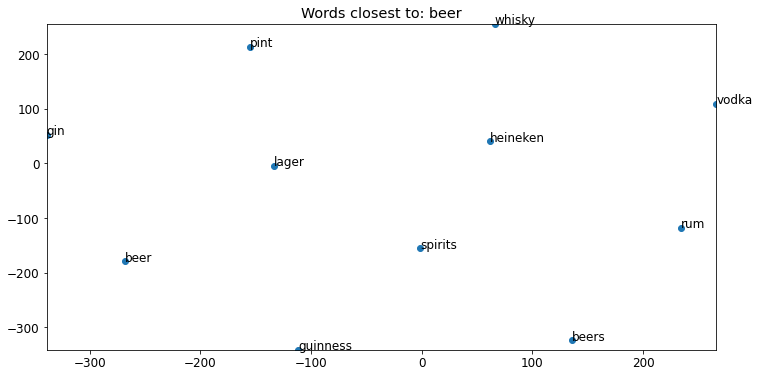

<IPython.core.display.Javascript object>

In [27]:
display_closestwords_tsnescatterplot(model.wv, "beer")

## ⚙️ Learning Domain-Specific Word Embeddings <a name="domain-specific_word_vectors"></a>

Word embeddings are interesting and thought provoking but
- What insights can we gain from them?
- How do we apply them to industry data?

This section of the notebook will explore word embeddings and their application to geological survey data (GSWA).

### Loading a small sample of Geological Survey of Western Australia (GSWA) data

In [28]:
gswa_corpus_file="../data/wamex_xml.zip"

<IPython.core.display.Javascript object>

In [29]:
gswa_corpus = list()
with zipfile.ZipFile(gswa_corpus_file, "r") as z:
    for filename in z.namelist():
        with z.open(filename) as f:
            # load the json file
            # The resulting `content` is a list
            content = json.loads(f.read()) 
            # Convert content to a string   
            content = "".join(content)
            # Add to the data list
            gswa_corpus.append(content)

<IPython.core.display.Javascript object>

By previewing the data that we have loaded, we can easily see that it is very different to the hotel reviews dataset.

In [30]:
print(gswa_corpus[0][:500])

Combined Reporting Application Pending Status: Sheet 1:250 000: Kalgoorlie (SH 51-09) Sheet 1:100 000: Kalgoorlie (3136) Project Operator: Cazaly Resources Limited Author: M Watts Date: September 2006 Distribution: 1.Department of Industry and Resources 2.Cazaly Resources Limited Cazaly Resources Limited September 2006 2 Figure 2: Castle Hill Project Tenement Location Plan, 1: 75 000 scale 6 Figure 3: Regional Geology with Exploration Index Map, 1:75 000 scale 8Cazaly Resources Limited September


<IPython.core.display.Javascript object>

In [31]:
def read_input(input_file):
    """This method reads the input file which is in zip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))

    data = list()
    with zipfile.ZipFile(input_file, "r") as z:
    #df = [pd.read_json(filename) for filename in z.namelist()]
        print(len(z.namelist()))
        for i, filename in enumerate(z.namelist()):
            # print(filename)
            # df = pd.read_json(filename)
            if (i%100==0):
                logging.info ("read {0} reports".format (i))
            with z.open(filename) as f:
                # load the json file
                # The resulting `content` is a list
                content = json.loads(f.read()) 
                # Convert content to a string   
                content = "".join(content)
                if len(content) >= 10:
                    # Add to the data list
                    yield gensim.utils.simple_preprocess (content)
                else:
                    logging.info("removed {0} because of small size".format (filename))

<IPython.core.display.Javascript object>

Here we'll perform basic pre-processing of the geological surveys using Gensim's `simple_preprocess` function. A result of this is a corpus of tokenized and cased documents.

In [32]:
processed_gswa_corpus = [gensim.utils.simple_preprocess(doc) for doc in gswa_corpus]

<IPython.core.display.Javascript object>

In [33]:
# Review the first documents top 25 words. See how they have been pre-processed and tokenized.
print(processed_gswa_corpus[0][:25])

['combined', 'reporting', 'application', 'pending', 'status', 'sheet', 'kalgoorlie', 'sh', 'sheet', 'kalgoorlie', 'project', 'operator', 'cazaly', 'resources', 'limited', 'author', 'watts', 'date', 'september', 'distribution', 'department', 'of', 'industry', 'and', 'resources']


<IPython.core.display.Javascript object>

### Training word embedding model off of domain-specific text.

Note: we are required to use bigrams to aid our model due to domain-specific terms.

📣 Similarly to the common corpora embeddings, we'll load pretrained vectors instead of training. However, if you want to investigate the impacts of hyperparameters on embedding representations, feel free to uncomment the code below.

In [34]:
gswa_modelpath = Path('../data/word2vec_gswa.bin').resolve()

<IPython.core.display.Javascript object>

In [35]:
gswa_model = gensim.models.Word2Vec.load(str(gswa_modelpath))

<IPython.core.display.Javascript object>

⚠️Training the domain-specific embeddings will take 30-60 minutes.

In [36]:
# Build phrases and bigrams to train our word2vec model on
# phrases = gensim.models.Phrases(processed_gswa_corpus, min_count=1, threshold=1)
# bigrams = gensim.models.phrases.Phraser(phrases)

<IPython.core.display.Javascript object>

In [37]:
# Note: we're referring to the model as gswa. This allows us
# to make a contrast between the pretrained word embeddings and the domain-specific ones. 
# gswa_model = gensim.models.Word2Vec(bigrams[processed_gswa_corpus], vector_size=50, window=10, min_count=2, workers=12, epochs=10)

<IPython.core.display.Javascript object>

In [38]:
# gswa_model.save("../data/word2vec_gswa.bin")

<IPython.core.display.Javascript object>

## Looking at domain-specific outputs

In [39]:
print(list(gswa_model.wv.key_to_index.keys())[:100])

['the', 'and', 'of', 'to', 'of_the', 'in', 'in_the', 'with', 'for', 'by', 'is', 'at', 'area', 'as', 'from', 'on_the', 'on', 'or', 'that', 'this', 'project', 'within_the', 'are', 'drilling', 'from_the', 'figure', 'gold', 'to_be', 'data', 'project_area', 'was', 'mineralisation', 'exploration', 'has_been', 'no', 'during_the', 'all', 'have_been', 'zone', 'report', 'pty_ltd', 'results', 'au', 'it_is', 'survey', 'within', 'sampling', 'samples', 'tenements', 'western_australia', 'the_tenement', 'will_be', 'were', 'ltd', 'some', 'table', 'be', 'number_of', 'mining', 'resource', 'the_north', 'but', 'tenement', 'associated_with', 'these', 'limited', 'up_to', 'which', 'coordinates_are', 'not_surveyed', 'are_integer', 'warning_coordinates', 'below', 'poss_not', 'integer_poss', 'two', 'australia', 'over_the', 'rocks', 'part_of', 'prospect', 'holes', 'between', 'rock_chip', 'annual_report', 'the_east', 'the_south', 'samples_were', 'has', 'can_be', 'gold_mineralisation', 'using', 'the_west', 'where',

<IPython.core.display.Javascript object>

In [40]:
prettify_similarities(gswa_model.wv.most_similar(['gold']))

1.	nickel                	88.1%
2.	copper                	83.8%
3.	lead                  	79.9%
4.	au                    	78.5%
5.	discovered_at         	74.9%
6.	worked_intermittently 	74.9%
7.	hosts_croesus         	73.1%
8.	minings_operations    	72.2%
9.	values_ranged         	71.8%
10.	base_metals           	71.6%


<IPython.core.display.Javascript object>

In [41]:
prettify_similarities(gswa_model.wv.most_similar(['iron']))

1.	sulphur         	85.4%
2.	fe              	83.5%
3.	silver          	82.3%
4.	co              	82.1%
5.	primary         	81.8%
6.	gangue_minerals 	81.4%
7.	hematite        	81.3%
8.	cobalt          	81.3%
9.	oxide           	80.6%
10.	phosphorous     	80.4%


<IPython.core.display.Javascript object>

In [42]:
# get everything related to stuff on the commodity
prettify_similarities(gswa_model.wv.most_similar(positive = ["gold",'commodity','ore'], negative = ['rock']))

1.	tonnes_grading 	89.4%
2.	of_million     	88.9%
3.	ounces         	84.9%
4.	oz             	84.7%
5.	hosts_croesus  	84.6%
6.	of_tonnes      	84.5%
7.	oz_au          	84.5%
8.	compliant      	82.7%
9.	ounces_of      	82.0%
10.	an_estimated   	82.0%


<IPython.core.display.Javascript object>

In [43]:
# similarity between two different words
print(f'Similarity between two different words: {gswa_model.wv.similarity(w1="gold",w2="ore"):0.3}')

Similarity between two different words: 0.436


<IPython.core.display.Javascript object>

In [44]:
# similarity between two identical words
print(f'Similarity between the same word: {gswa_model.wv.similarity(w1="gold",w2="gold"):0.3}')

Similarity between the same word: 1.0


<IPython.core.display.Javascript object>

In [45]:
# similarity between two unrelated words
print(f'Similarity between unrelated words: {gswa_model.wv.similarity(w1="gold",w2="rock"):0.3}')

Similarity between unrelated words: -0.0991


<IPython.core.display.Javascript object>

In [46]:
# Which one is the odd one out in this list?
odd_one_out_list_gswa = ["gold", "rock", "copper"]
print(f'Which words doesnt belong in the set {odd_one_out_list_gswa}? Odd one out: {gswa_model.wv.doesnt_match(odd_one_out_list_gswa)}')

Which words doesnt belong in the set ['gold', 'rock', 'copper']? Odd one out: rock


<IPython.core.display.Javascript object>

### Comparing our domain-specific embeddings with embeddings trained on a different dataset (news articles).

- What are the nearest terms to 'commodity', 'ore', 'rock', etc.

Unfortunately due to the size of pre-trained word embedding models they have been omitted from this comparison. However, the code below shows how to load the Google news word2vec embedding model. This model is trained on 100 billion words and is 1.6GB in size (massive!).

In [47]:
# Define function to compare top-n similariries for a given word between two embedding models.
def compare_words(word, topn, model1, model2):
    similarWordsModel1 = model1.wv.most_similar(positive=word, topn=topn)
    similarWordsModel2 = model2.wv.most_similar(positive=word,topn=topn)

    print(f'Top {topn} words similar to {word}\n(format: n | model 1 | model 2 )\n')
    for n in range(topn):
        print(f'{n+1} |{similarWordsModel1[n][0]:<15} | {similarWordsModel2[n][0]:<15}')

<IPython.core.display.Javascript object>

In [48]:
# Looking at the word 'commodity'
compare_words(word = 'commodity', topn = 5, model1 = model, model2 = gswa_model)

Top 5 words similar to commodity
(format: n | model 1 | model 2 )

1 |rarity          | feasibility    
2 |nowadays        | nl_lrn         
3 |nutrition       | through_utilisation
4 |rare            | oxide_resource 
5 |extreme         | by_integra     


<IPython.core.display.Javascript object>

In [49]:
# Looking at the word 'ore'
compare_words(word = 'ore', topn = 5, model1 = model, model2 = gswa_model)

Top 5 words similar to ore
(format: n | model 1 | model 2 )

1 |tutti           | grade          
2 |beaucoup        | gold_price     
3 |mois            | tonnes         
4 |kw              | mined          
5 |su              | oz             


<IPython.core.display.Javascript object>

In [50]:
# Looking at the word 'rock'
compare_words(word = 'rock', topn = 5, model1 = model, model2 = gswa_model)

Top 5 words similar to rock
(format: n | model 1 | model 2 )

1 |rocks           | feldspar       
2 |earned          | magnetite      
3 |boiled          | trace          
4 |snapper         | goethite       
5 |governments     | carbonate      


<IPython.core.display.Javascript object>

### Visualising the domain-specific word vectors in 2D space

In [51]:
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0,50), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, perplexity=30 if len(arr) > 30 else len(arr)-1)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

<IPython.core.display.Javascript object>

c:\Users\Tyler\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Tyler\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


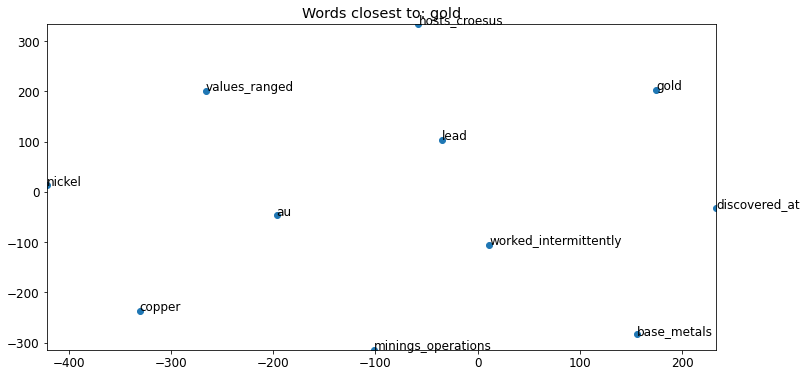

<IPython.core.display.Javascript object>

In [52]:
display_closestwords_tsnescatterplot(model = gswa_model.wv, word = "gold")

### Visualising all of the words in the domain-specific corpus vocabulary

In [53]:
# Set-up t-SNE model for 2 dimensional reduction
tsne = TSNE(n_components=2)

<IPython.core.display.Javascript object>

In [54]:
X = gswa_model.wv[gswa_model.wv.key_to_index]
# Shape of our model before t-SNE
print(f'Shape of model before t-SNE: {X.shape}')

Shape of model before t-SNE: (118241, 50)


<IPython.core.display.Javascript object>

Here we'll fit a t-SNE model to our data. However, as our corpus is quite large, we'll first subset it to help with comptuation time.

In [55]:
# Number of points to model
points = 2500

<IPython.core.display.Javascript object>

In [56]:
# Fitting subset of data to t-SNE
X_limited = X[:points]
X_tsne = tsne.fit_transform(X_limited)

# Uncomment line below to fit entire model to t-SNE
# X_tsne = tsne.fit_transform(X)

c:\Users\Tyler\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Tyler\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>

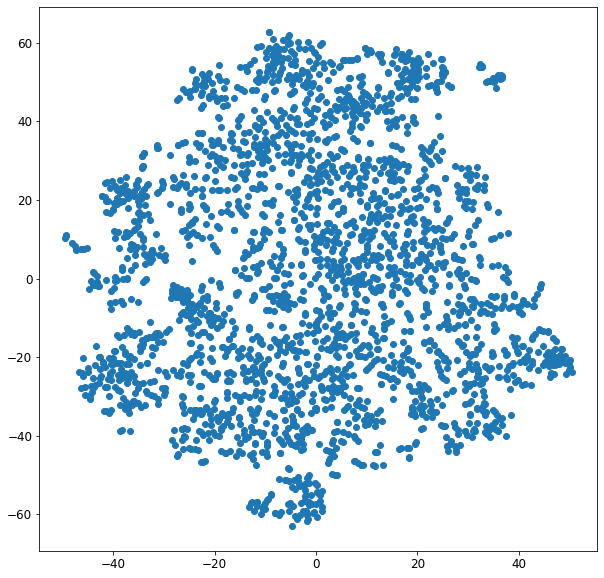

<IPython.core.display.Javascript object>

In [57]:
# Plot dimensionality reduced word scatterplot
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

### Interactive Visualisation


Refer to https://www.datascience.com/resources/notebooks/word-embeddings-in-python, and also for ideas of incoporating POS and bigrams into word2vec training.

In [58]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, width=700, height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

<IPython.core.display.Javascript object>

Launch interactive visualisation of word embeddings

In [59]:
interactive_tsne(list(gswa_model.wv.key_to_index)[:points], X_tsne)

Loading BokehJS ...

<IPython.core.display.Javascript object>